# Import Library

In [1]:
# Data Loading
import xarray as xr  
import urllib

# Data Processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.basemap import Basemap, maskoceans

# Ignore warning messages
import warnings
warnings.filterwarnings(action='ignore')

# Data Load

In [2]:
# https://psl.noaa.gov/data/gridded/data.gpcp.html (precipitation)
path_precip = './precip.mon.mean.nc'
precip_data = xr.open_dataset(path_precip)

print(precip_data) # print dataset infomation 

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 496)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-04-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] ...
    lat_bnds   (lat, nv) float32 ...
    lon_bnds   (lon, nv) float32 ...
    precip     (time, lat, lon) float32 ...
Attributes:
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    documentation:  

In [3]:
### How to read data from url
url = 'https://psl.noaa.gov/data/correlation/nina34.data'
file = urllib.request.urlopen(url)

Nino34_read = []
for i, line in enumerate(file):
    decoded_line = line.decode('utf-8')
    
    if i == 0:
        year_start, year_end = decoded_line.split()
    else:
        year = decoded_line.split()[0]
        Nino34_read.append(decoded_line.split()[1:])

        if year == year_end:
            break
            
Nino34_read = np.array(Nino34_read).flatten().astype(np.float32)
Nino34_read[Nino34_read == -99.99] = np.NaN   # set null value

### create xarray type dataset
# http://xarray.pydata.org/en/stable/data-structures.html

times = pd.date_range(year_start+'-01-01', periods=len(Nino34_read), freq='1M')
Nino34_data = xr.Dataset(
    {'Nino3.4' : (['time'], Nino34_read)},
    coords = {'time': pd.date_range(year_start+'-01-01', periods=len(Nino34_read), freq='1M')}
)

print(Nino34_data)

<xarray.Dataset>
Dimensions:  (time: 876)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-31 1948-02-29 ... 2020-12-31
Data variables:
    Nino3.4  (time) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan


# Data Processing

In [4]:
# select variable
precip = precip_data.data_vars['precip']
N34 = Nino34_data.data_vars['Nino3.4']

print(precip.shape)
print(N34.shape)

(496, 72, 144)
(876,)


In [5]:
# Convert longitude coordinates from 0-359 to -180-179:
# http://xarray.pydata.org/en/stable/generated/xarray.Dataset.assign_coords.html

precip_ = precip.assign_coords({"lon": (((precip.lon + 180) % 360) - 180)})
precip_ = precip_.sortby('lon')

In [6]:
# Select North Africa
p_North_Africa = precip_.sel(lon=slice(-25,65), lat=slice(-10,40))

In [7]:
# Yearly mean of July-Semtember (JAS) 
p_North_Africa_JJA = p_North_Africa[p_North_Africa['time'].dt.month.isin([7,8,9])].groupby('time.year').mean('time')

# Yearly mean of winter (DJF) 
N34_DJF = N34[N34['time'].dt.season == 'DJF'].groupby('time.year').mean('time')

## Correlation

In [8]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def corrrelation(x, y, dims=None):
    x.year.data = y.year.data   # trick time to be equal
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

In [9]:
# lead-lag correlation map
leadlag_corr = []

year_start = 1982
year_end = 2000
leadlag_idx = [-3, -2, -1, 0 ,1 ,2 ,3]

for i in leadlag_idx:
    p_time_idx = np.where((p_North_Africa_JJA.year.values >= year_start) & (p_North_Africa_JJA.year.values <= year_end))
    n_time_idx = np.where((N34_DJF.year.values >= year_start+i+1) & (N34_DJF.year.values <= year_end+i+1))
    
    leadlag_corr.append(corrrelation(p_North_Africa_JJA[p_time_idx], N34_DJF[n_time_idx], dims='year'))

# Visualization

In [10]:
def leadlag_plot(x, ax, leadlag_idx, cbar=False):
    
    m = Basemap(
    lon_0=0, lat_0=0, # center of mat domain
    llcrnrlon=-20., llcrnrlat=-5., urcrnrlon=60., urcrnrlat=35., # projection region
        resolution='l', # boundary resolution (c, l, i, h, f)
        ax=ax
    )
    
    coord = np.meshgrid(x.lon, x.lat)
    m.drawcoastlines(linewidth=0.5, color='k') # draw coastline
    masked_x = maskoceans(coord[0], coord[1], x)
    
    cs = m.contourf(coord[0], coord[1], masked_x,
            cmap=plt.cm.RdBu_r,  # reverse colormap order
            vmax=0.6, vmin=-0.6,
            levels=12,
        )
    
    ax.set_title('YR'+str(leadlag_idx), fontsize=20)
    
    if cbar:
        return cs

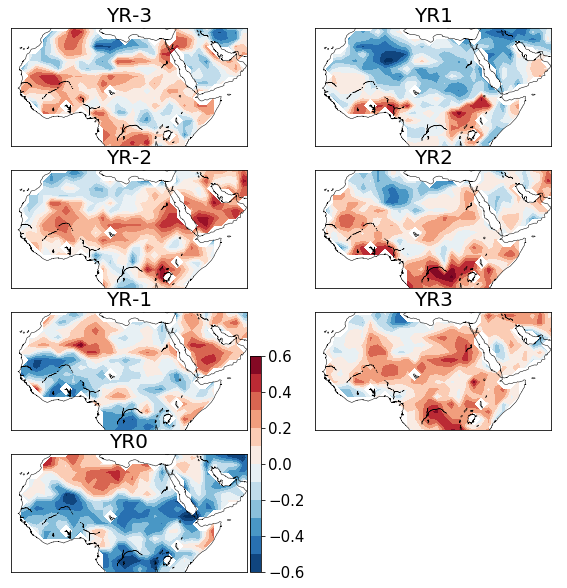

In [11]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,10))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

leadlag_plot(leadlag_corr[0], ax[0][0], leadlag_idx[0])
leadlag_plot(leadlag_corr[1], ax[1][0], leadlag_idx[1])
leadlag_plot(leadlag_corr[2], ax[2][0], leadlag_idx[2])
leadlag_plot(leadlag_corr[3], ax[3][0], leadlag_idx[3])
leadlag_plot(leadlag_corr[4], ax[0][1], leadlag_idx[4])
leadlag_plot(leadlag_corr[5], ax[1][1], leadlag_idx[5])
cs = leadlag_plot(leadlag_corr[6], ax[2][1], leadlag_idx[6], cbar=True)

ax[3][1].axis('off')    # make empty    

# colobar options
cb_ax = fig.add_axes([0.47, 0.125, 0.015, 0.3])
cbar = fig.colorbar(cs, cax=cb_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks(np.linspace(-0.60, 0.6, 7))

plt.show()